In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd
import os
from scipy.integrate import odeint

In [256]:
window_size = 30
N_status = 'free'
country = 'UK'
samples = '3k'

if country == 'UK':
    location = 'United Kingdom'
elif country == 'India':
    location = 'India'
elif country == 'USA':
    location = 'United States'

path = f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/logs/{window_size}_N_{N_status}_{country}'
data_path = f'{path}/Posterior5/{location}/SEIRD'

In [257]:
if samples == '3k':
    path = f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/logs/{window_size}_N_{N_status}_{country}_{samples}_samples'
    data_path = f'{path}/Posterior5/{location}/SEIRD'

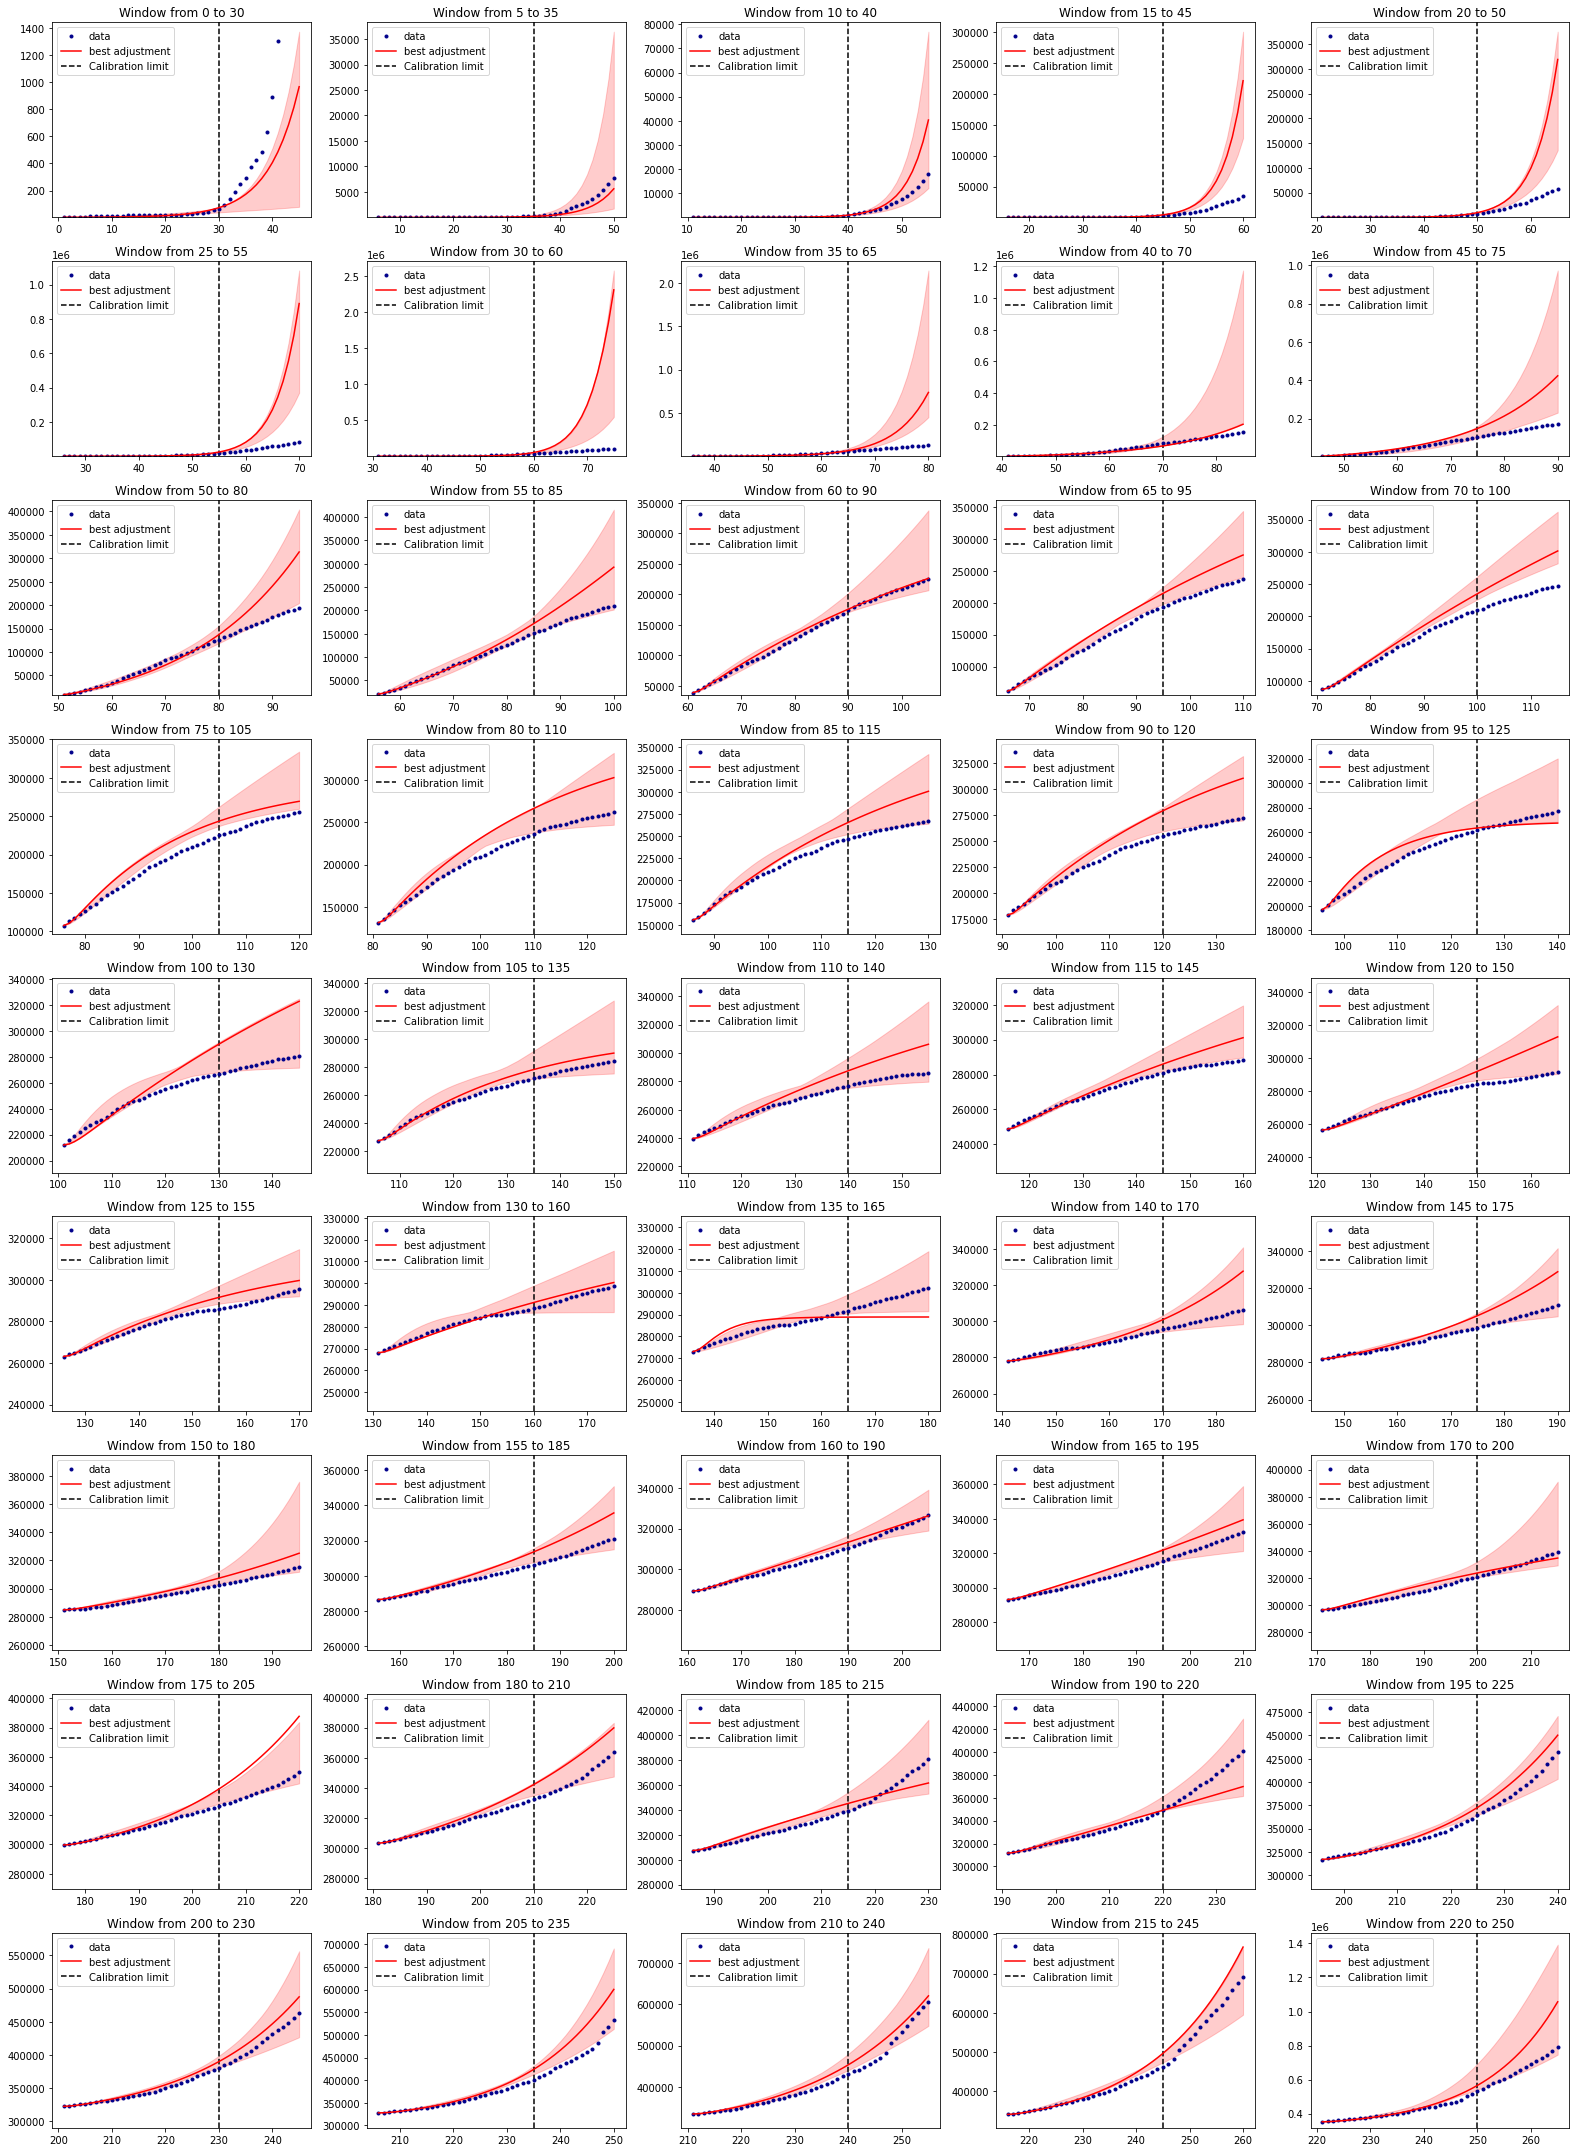

In [258]:
post_total = {}
val_error_total = []

windows = []

for i in range(len(os.listdir(data_path))):
    name = int(window_size + 5*i)
    windows.append(f'{name}_days')

for window in windows:
    files = os.listdir(f'{data_path}/{window}')
    if len(files) > 0:
        post = np.loadtxt(f'{data_path}/{window}/post.txt')
        val_error = np.loadtxt(f'{data_path}/{window}/val_error.txt')
        #print(window)
        #print(post.shape)
        #print(val_error.shape)
        post_total[window] = post
        val_error_total.append(val_error)

fig, ax = plt.subplots(9,5,figsize=(22,30))
for idx, key in enumerate(post_total):
    a = pd.DataFrame(post_total[key])
    #print(a.shape)
    b = a.sort_values(7).head(15).reset_index(drop=True)
    dados = np.loadtxt(f'{path}/Posterior1/{location}/SEIRD/{key}/data.txt')
    #print(len(dados))
    curves = []
    for i in range(len(b)):
        def SEIRD(x, t):
            S = x[0]
            E = x[1]
            I = x[2]
            R = x[3]
            M = x[4]
            if N_status == 'free':
                bet = b[0][i]
                a = b[4][i]
                mu = b[3][i]
                c = b[5][i]
                k = b[1][i]
            else:
                bet = b[0][i]
                a = b[3][i]
                mu = b[2][i]
                c = b[4][i]
                k = b[1][i]
            dSdt = -bet*I*S/N - k*E*S/N
            dEdt = bet*I*S/N + k*E*S/N - E/c
            dIdt = E/c - a*I - mu*I
            dRdt = a*I
            dMdt = mu*I
            return [dSdt, dEdt, dIdt, dRdt, dMdt]

        if N_status == 'free':
            N = b[2][i]
            I0 = dados[0,1]*(1-b[6][i])
            E0 = dados[0,1]*b[7][i]
            R0 = dados[0,1]*b[6][i]
            M0 = dados[0,0]
        elif N_status == 'fixed' and country == 'UK':
            N = 1e7
            I0 = dados[0,1]*(1-b[5][i])
            E0 = dados[0,1]*b[6][i]
            R0 = dados[0,1]*b[5][i]
            M0 = dados[0,0]
        elif N_status == '5e6' and country == 'UK':
            N = 5e6
            I0 = dados[0,1]*(1-b[5][i])
            E0 = dados[0,1]*b[6][i]
            R0 = dados[0,1]*b[5][i]
            M0 = dados[0,0]
        elif N_status == 'pop' and country == 'UK':
            N = 66.65e6
            I0 = dados[0,1]*(1-b[5][i])
            E0 = dados[0,1]*b[6][i]
            R0 = dados[0,1]*b[5][i]
            M0 = dados[0,0]
        elif N_status == '3e7' and country == 'India':
            N = 3e7
            I0 = dados[0,1]*(1-b[5][i])
            E0 = dados[0,1]*b[6][i]
            R0 = dados[0,1]*b[5][i]
            M0 = dados[0,0]
        elif N_status == '6e7' and country == 'India':
            N = 6e7
            I0 = dados[0,1]*(1-b[5][i])
            E0 = dados[0,1]*b[6][i]
            R0 = dados[0,1]*b[5][i]
            M0 = dados[0,0]

        x0 = [N-I0,E0,I0,R0,M0]
        t = np.linspace(0, window_size+15, window_size+15)
        x = odeint(SEIRD, x0, t)

        S = x[:,0]
        E = x[:,1]
        I = x[:,2]
        R = x[:,3]
        M = x[:,4]
        CT = M + R + I
        curves.append(CT)
    
    curves = np.array(curves)

    mean_curve = np.median(curves, axis = 0)
    low_CI_curve = []
    up_CI_curve = []

    for i in range(window_size+15):
        low_CI_curve.append(np.percentile(curves[:,i],2.5))
        up_CI_curve.append(np.percentile(curves[:,i], 97.5))

    low_CI_curve = np.array(low_CI_curve)
    up_CI_curve = np.array(up_CI_curve)

    if idx < 5:
        ax[0,idx].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[0,idx].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[0,idx].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[0,idx].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[0,idx].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[0,idx].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[0,idx].legend(loc = 'upper left')
    elif idx >= 5 and idx < 10:
        ax[1,idx-5].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[1,idx-5].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[1,idx-5].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[1,idx-5].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[1,idx-5].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[1,idx-5].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[1,idx-5].legend(loc = 'upper left')
    elif idx >= 10 and idx < 15:
        ax[2,idx-10].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[2,idx-10].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[2,idx-10].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[2,idx-10].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[2,idx-10].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[2,idx-10].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[2,idx-10].legend(loc = 'upper left')
    elif idx >= 15 and idx < 20:
        ax[3,idx-15].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[3,idx-15].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[3,idx-15].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[3,idx-15].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[3,idx-15].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[3,idx-15].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[3,idx-15].legend(loc = 'upper left')
    elif idx >= 20 and idx < 25:
        ax[4,idx-20].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[4,idx-20].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[4,idx-20].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[4,idx-20].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[4,idx-20].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[4,idx-20].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[4,idx-20].legend(loc = 'upper left')
    elif idx >= 25 and idx < 30:
        ax[5,idx-25].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[5,idx-25].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[5,idx-25].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[5,idx-25].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[5,idx-25].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[5,idx-25].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[5,idx-25].legend(loc = 'upper left')
    elif idx >= 30 and idx < 35:
        ax[6,idx-30].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[6,idx-30].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[6,idx-30].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[6,idx-30].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[6,idx-30].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[6,idx-30].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[6,idx-30].legend(loc = 'upper left')
    elif idx >= 35 and idx < 40:
        ax[7,idx-35].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[7,idx-35].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[7,idx-35].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[7,idx-35].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[7,idx-35].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[7,idx-35].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[7,idx-35].legend(loc = 'upper left')
    elif idx >= 40 and idx < 45:
        ax[8,idx-40].plot(dados[:,0], dados[:,1], '.', color = 'darkblue', label = 'data')
        ax[8,idx-40].plot(dados[:,0], curves[0,:], color = 'red', label = 'best adjustment')
        #plt.plot(dados[:,0], mean_curve, color = 'purple')
        ax[8,idx-40].fill_between(dados[:,0], low_CI_curve, up_CI_curve, color = 'red',
                        alpha = 0.2)
        ax[8,idx-40].vlines(float(key.split('_')[0]), 0.9*dados[0,1], 1.05*up_CI_curve[-1], linestyle = 'dashed', label = 'Calibration limit')
        ax[8,idx-40].set_ylim(0.9*dados[0,1], 1.05*up_CI_curve[-1])
        ax[8,idx-40].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[8,idx-40].legend(loc = 'upper left')
plt.tight_layout()
#plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/{window_size}_day_window_N_{N_status}_{country}&SEIRD_norm_by_daily_cases_{samples}_samples.png',
#            bbox_inches = 'tight', dpi = 300)

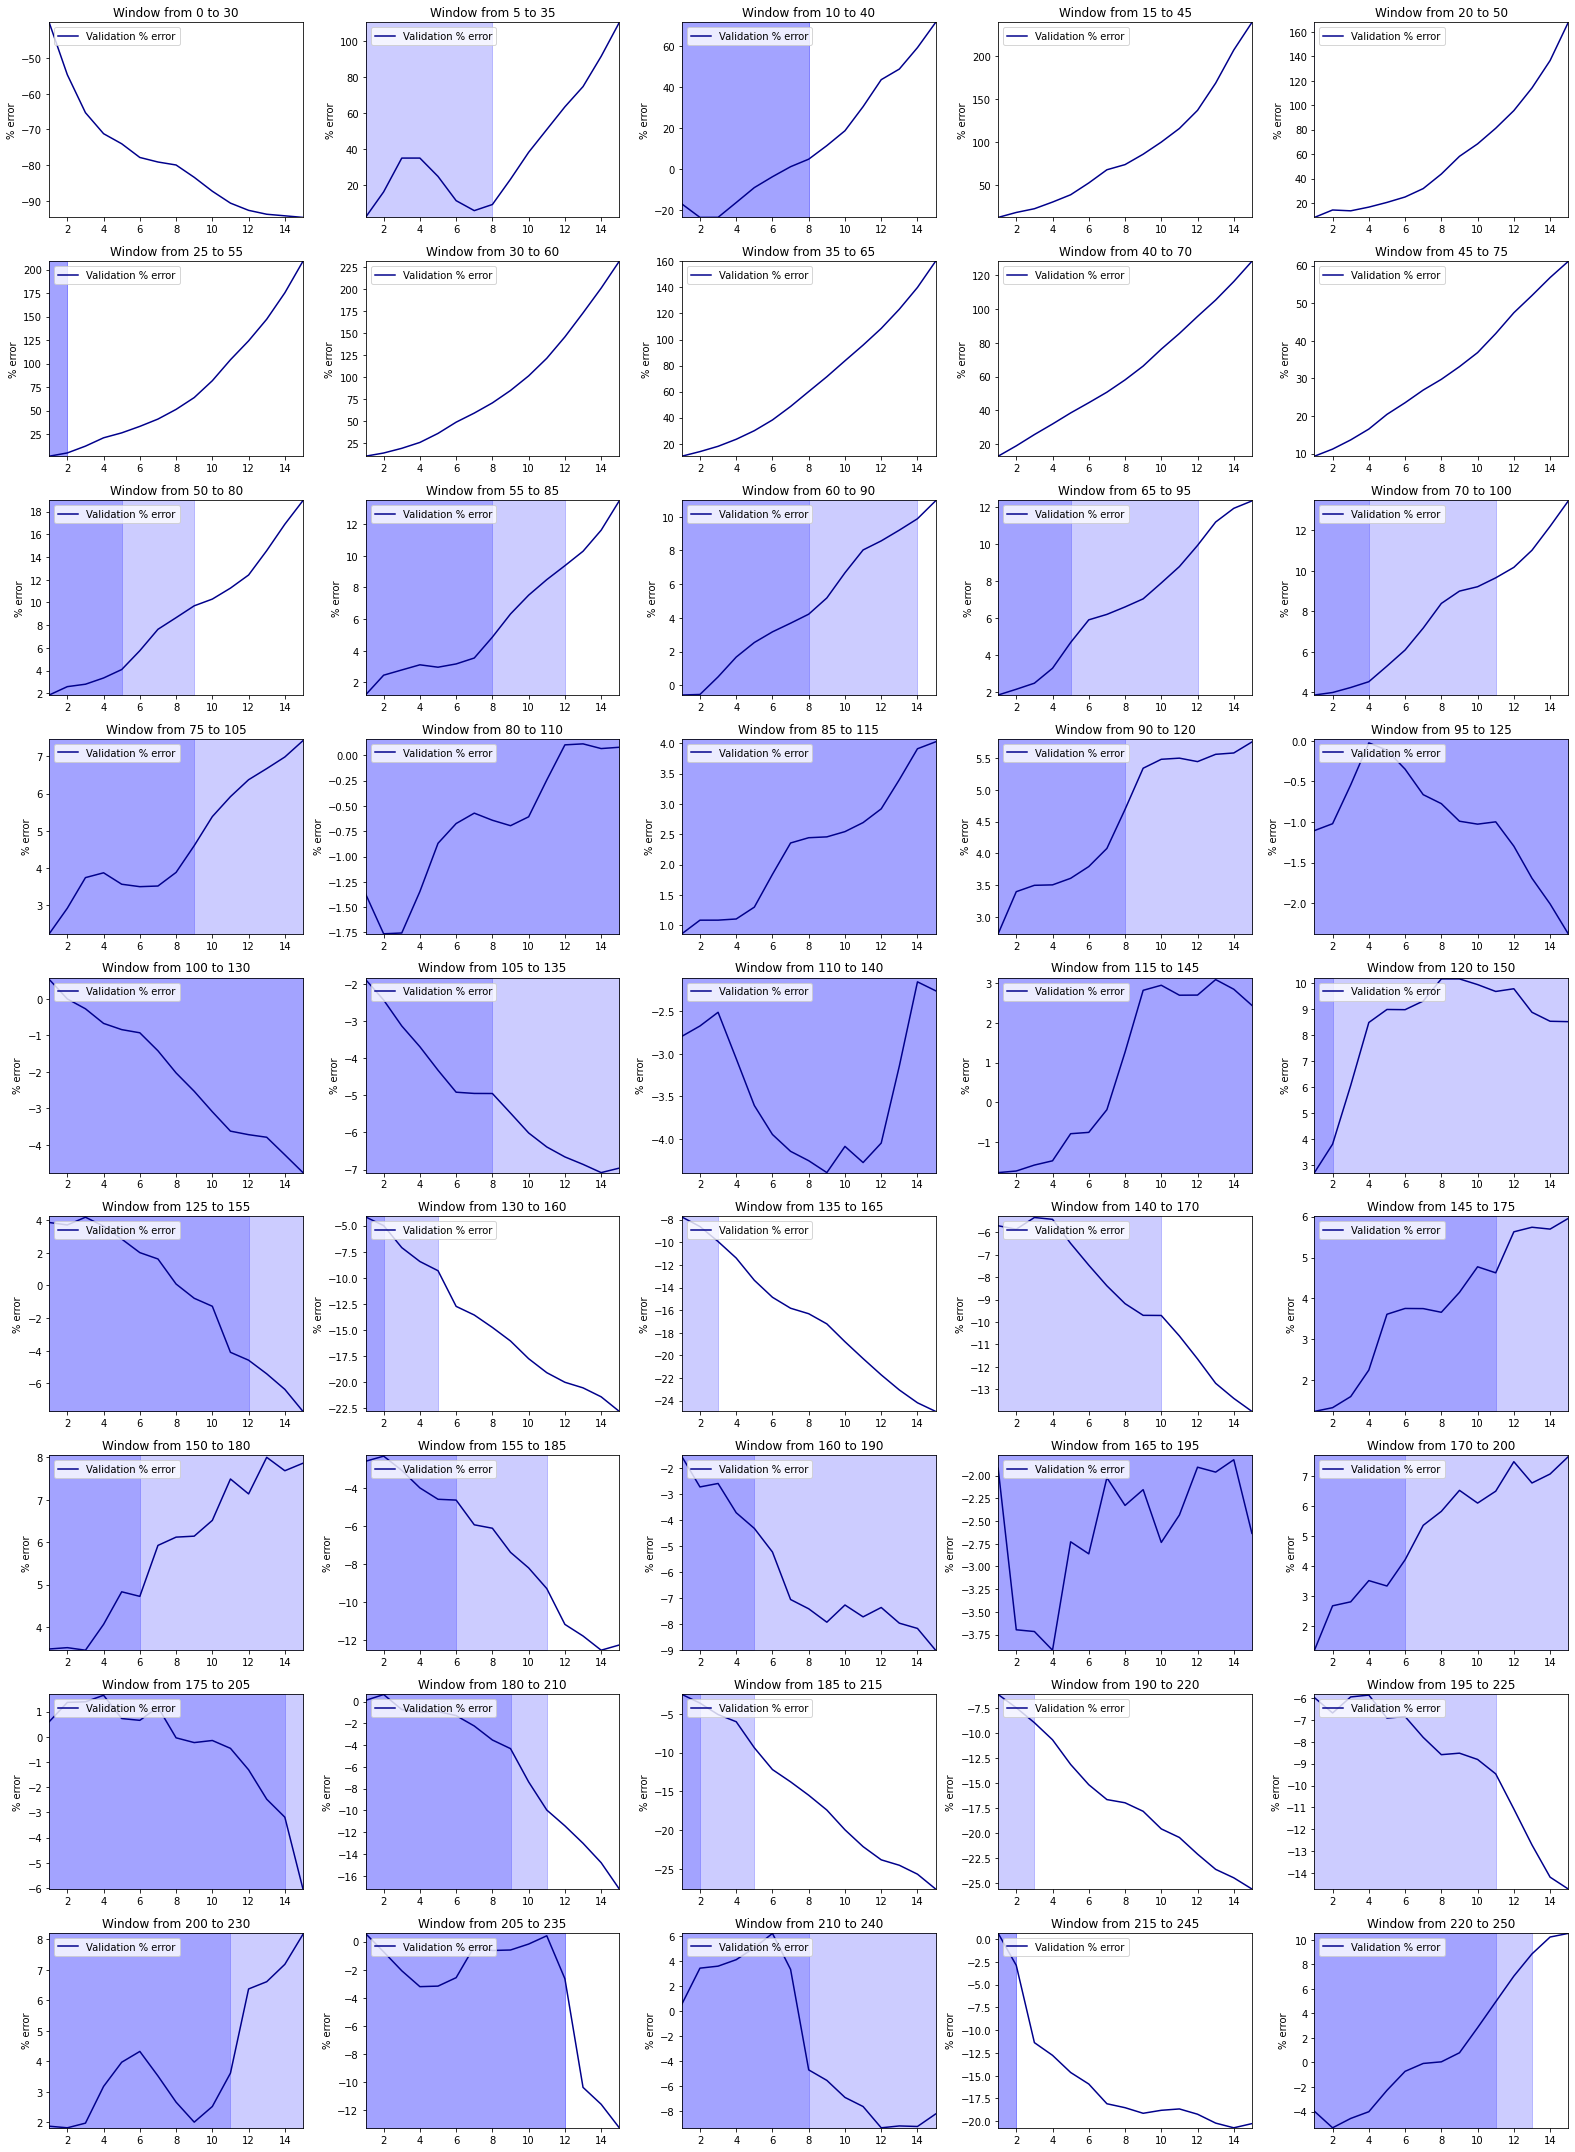

In [259]:
post_total = {}
val_error_total = {}
val_err = {}
prediction_power = []
prediction_not_much_power = []

windows = []

for i in range(len(os.listdir(data_path))):
    name = int(window_size + 5*i)
    windows.append(f'{name}_days')

for window in windows:
    files = os.listdir(f'{data_path}/{window}')
    if len(files) > 0:
        post = np.loadtxt(f'{data_path}/{window}/post.txt')
        val_error = np.loadtxt(f'{data_path}/{window}/val_error.txt')
        post_total[window] = post
        val_error_total[window] = val_error[0]
        #val_err[window] = val_error[0]

fig, ax = plt.subplots(9,5,figsize=(22,30))
for idx, key in enumerate(val_error_total):
    a = -val_error_total[key]
    dados = np.loadtxt(f'{path}/Posterior1/{location}/SEIRD/{key}/data.txt')
    days = np.linspace(1,15,15)
    pred = days[np.where(np.abs(100*a/dados[window_size:,1]) <= 5)[0]]
    pred2 = days[np.where(np.abs(100*a/dados[window_size:,1]) <= 10)[0]]
    if len(pred) > 0:
        prediction_power.append(pred[-1])
    else:
        prediction_power.append(0)
    if len(pred2) > 0:
        prediction_not_much_power.append(pred2[-1])
    else:
        prediction_not_much_power.append(0)

    if 0 in (dados[window_size:,1] - dados[0,1]):
        err = [100 for i in range(len(dados[window_size:,1]))]
        val_err[key] = err
    else:
        err = 100*a/(dados[window_size:,1] - dados[0,1])
        val_err[key] = err
    #print(err)
    if idx < 5:
        ax[0,idx].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[0,idx].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[0,idx].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[0,idx].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[0,idx].legend(loc = 'upper left')
        ax[0,idx].set_ylabel('% error')
        ax[0,idx].set_xlim(1,15)
        ax[0,idx].set_ylim(min(err), max(err)+0.05)
    elif idx >=5 and idx < 10:
        ax[1,idx-5].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[1,idx-5].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[1,idx-5].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[1,idx-5].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[1,idx-5].legend(loc = 'upper left')
        ax[1,idx-5].set_ylabel('% error')
        ax[1,idx-5].set_xlim(1,15)
        ax[1,idx-5].set_ylim(min(err), max(err)+0.05)
    elif idx >= 10 and idx < 15:
        ax[2,idx-10].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[2,idx-10].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[2,idx-10].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[2,idx-10].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[2,idx-10].legend(loc = 'upper left')
        ax[2,idx-10].set_ylabel('% error')
        ax[2,idx-10].set_xlim(1,15)
        ax[2,idx-10].set_ylim(min(err), max(err)+0.05)
    elif idx >= 15 and idx < 20:
        ax[3,idx-15].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[3,idx-15].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[3,idx-15].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[3,idx-15].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[3,idx-15].legend(loc = 'upper left')
        ax[3,idx-15].set_ylabel('% error')
        ax[3,idx-15].set_xlim(1,15)
        ax[3,idx-15].set_ylim(min(err), max(err)+0.05)
    elif idx >= 20 and idx < 25:
        ax[4,idx-20].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[4,idx-20].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[4,idx-20].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[4,idx-20].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[4,idx-20].legend(loc = 'upper left')
        ax[4,idx-20].set_ylabel('% error')
        ax[4,idx-20].set_xlim(1,15)
        ax[4,idx-20].set_ylim(min(err), max(err)+0.05)
    elif idx >= 25 and idx < 30:
        ax[5,idx-25].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[5,idx-25].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[5,idx-25].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[5,idx-25].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[5,idx-25].legend(loc = 'upper left')
        ax[5,idx-25].set_ylabel('% error')
        ax[5,idx-25].set_xlim(1,15)
        ax[5,idx-25].set_ylim(min(err), max(err)+0.05)
    elif idx >= 30 and idx < 35:
        ax[6,idx-30].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[6,idx-30].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[6,idx-30].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[6,idx-30].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[6,idx-30].legend(loc = 'upper left')
        ax[6,idx-30].set_ylabel('% error')
        ax[6,idx-30].set_xlim(1,15)
        ax[6,idx-30].set_ylim(min(err), max(err)+0.05)
    elif idx >= 35 and idx < 40:
        ax[7,idx-35].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[7,idx-35].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[7,idx-35].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[7,idx-35].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[7,idx-35].legend(loc = 'upper left')
        ax[7,idx-35].set_ylabel('% error')
        ax[7,idx-35].set_xlim(1,15)
        ax[7,idx-35].set_ylim(min(err), max(err)+0.05)
    elif idx >= 40 and idx < 45:
        ax[8,idx-40].plot(days, err, color = 'darkblue', label = 'Validation % error')
        if len(days[np.where(np.abs(err) <= 5)[0]]) > 0:
            ax[8,idx-40].fill_between([1,days[np.where(np.abs(err) <= 5)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        if len(days[np.where(np.abs(err) <= 10)[0]]) > 0:
            ax[8,idx-40].fill_between([1,days[np.where(np.abs(err) <= 10)[0][-1]]],
                                    min(err), max(err)+0.05,
                                   color = 'blue', alpha = 0.2)
        ax[8,idx-40].set_title(f"Window from {int(float(key.split('_')[0])-window_size)} to {key.split('_')[0]}")
        ax[8,idx-40].legend(loc = 'upper left')
        ax[8,idx-40].set_ylabel('% error')
        ax[8,idx-40].set_xlim(1,15)
        ax[8,idx-40].set_ylim(min(err), max(err)+0.05)
plt.tight_layout()
#plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/{window_size}_day_window_N_{N_status}_{country}&SEIRD_prediction_error_norm_by_daily_cases_{samples}_samples.png',
#            bbox_inches = 'tight', dpi = 300)

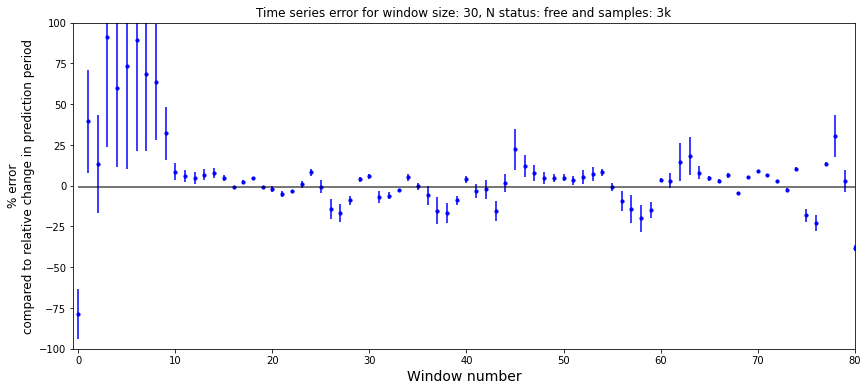

In [260]:
val_err = pd.DataFrame(val_err)

if country == 'UK':
    color = 'blue'
elif country == 'India':
    color = 'green'
elif country == 'USA':
    color = 'red'

fig = plt.figure(figsize=(14,6))
for idx, key in enumerate(val_err):
#     plt.boxplot(val_err[key], patch_artist=True, medianprops=dict(color='black'),
#                boxprops=dict(facecolor='lightblue'),
#                vert = True, positions = [idx], widths = [0.2], showfliers = False, whis = (2.5,97.5))
    plt.scatter(idx, np.mean(val_err[key]), s = 10, color = color)
    low, up = st.t.interval(0.95, df = len(val_err[key]), loc = np.mean(val_err[key]),
                            scale = st.sem(val_err[key]))
    #print(low, up, np.mean(val_err[key]))
    plt.errorbar(idx, np.mean(val_err[key]), yerr = np.std(val_err[key]), fmt = 'none', color = color)
plt.hlines(-0.5, 0, 90, color = 'black', alpha = 0.7)
plt.xlim(-0.5, 80)
plt.title(f'Time series error for window size: {window_size}, N status: {N_status} and samples: {samples}')
plt.xlabel('Window number', fontsize = 14)
plt.ylabel('% error'
           '\n'
           'compared to relative change in prediction period', fontsize = 12)
plt.ylim(-100,100)
fig.patch.set_alpha(0)
for ax in fig.axes:
    ax.patch.set_alpha(0)
plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/{window_size}_day_window_N_{N_status}_{country}&SEIRD_prediction_error_norm_by_daily_cases_{samples}_samples_time_series.png',
            bbox_inches = 'tight', dpi = 300)

In [73]:
post_total = {}
val_error_total = []
betas = {}
betas_E = {}
mus = {}
gammas = {}
taus = {}

windows = sorted(os.listdir(data_path))

for window in windows:
    files = os.listdir(f'{data_path}/{window}')
    if len(files) > 0:
        post = np.loadtxt(f'{data_path}/{window}/post.txt')
        val_error = np.loadtxt(f'{data_path}/{window}/val_error.txt')
#         print(window)
#         print(post.shape)
#         print(val_error.shape)
        post_total[window] = post
        val_error_total.append(val_error)
        
for idx, key in enumerate(post_total):
    a = pd.DataFrame(post_total[key])
    b = a.sort_values(7).head(15).reset_index(drop=True)
    if N_status == 'free':
        betas[key] = b[0][0]
        betas_E[key] = b[1][0]
        mus[key] = b[3][0]
        gammas[key] = b[4][0]
        taus[key] = b[5][0]
    else:
        betas[key] = b[0][0]
        betas_E[key] = b[1][0]
        mus[key] = b[2][0]
        gammas[key] = b[3][0]
        taus[key] = b[4][0]

In [74]:
beta = {}
beta_E = {}
mu = {}
gamma = {}
tau = {}
for idx, key in enumerate(betas):
    last_day = float(key.split('_')[0])
    x = np.linspace(last_day-window_size, last_day, window_size)
    beta[key] = [np.nan for i in range(425)]
    beta_E[key] = [np.nan for i in range(425)]
    mu[key] = [np.nan for i in range(425)]
    gamma[key] = [np.nan for i in range(425)]
    tau[key] = [np.nan for i in range(425)]
    for i in range(len(beta[key])):
        if i >= last_day-window_size and i <= last_day:
            beta[key][i] = betas[key]
            beta_E[key][i] = betas_E[key]
            mu[key][i] = mus[key]
            gamma[key][i] = gammas[key]
            tau[key][i] = taus[key]
    #plt.plot(x, beta)

In [75]:
beta_mean = pd.DataFrame(beta).mean(axis=1)
beta_E_mean = pd.DataFrame(beta_E).mean(axis=1)
mu_mean = pd.DataFrame(mu).mean(axis=1)
gamma_mean = pd.DataFrame(gamma).mean(axis=1)
tau_mean = pd.DataFrame(tau).mean(axis=1)

$$ R_0 = \frac{\beta_I \beta_E + \beta_E/\tau}{(\gamma + \mu)/\tau} $$

In [76]:
def R0(beta, beta_E, mu, gamma, tau):
    return (beta*beta_E + beta_E/tau)/((gamma + mu)/tau)

In [77]:
df = pd.read_csv('/home/pedroc/Documentos/pedro/Our World In Data/owid-covid-data.csv')

In [78]:
uk = df.loc[df['location'] == location]
uk['date'] = pd.to_datetime(uk['date'], format = '%Y-%m-%d')

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
daily = np.array(uk['new_cases_smoothed'].values)
rt = np.array(uk['reproduction_rate'].values)

daily = np.nan_to_num(daily)
rt = np.nan_to_num(rt)

In [80]:
pearson_corr, pearson_p = st.pearsonr(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean), daily[:425])

In [81]:
spearman_corr, spearman_p = st.spearmanr(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean), daily[:425])

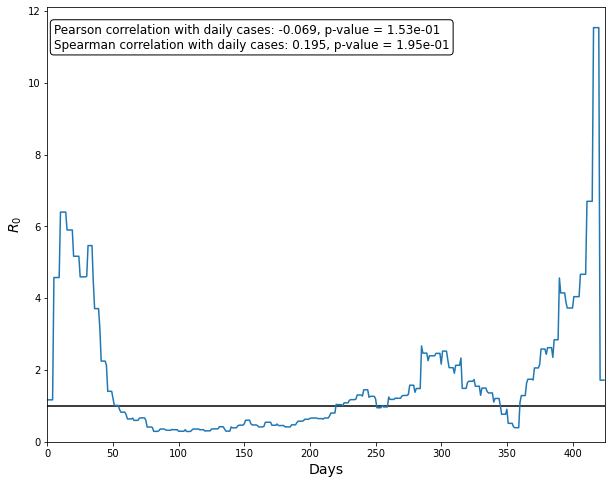

In [82]:
plt.figure(figsize=(10,8))
plt.plot(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean))
plt.hlines(1, 0, 425)
plt.xlim(0, 425)
plt.xlabel('Days', fontsize = 14)
plt.ylabel(r'$R_0$', fontsize = 14)
plt.text(5, 0.95*max(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean)),
         f'Pearson correlation with daily cases: {pearson_corr:.3f}, p-value = {pearson_p:.2e}'
         '\n'
         f'Spearman correlation with daily cases: {spearman_corr:.3f}, p-value = {spearman_corr:.2e}',
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), fontsize = 12)
plt.ylim(0, 1.05*max(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean)))
plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/{window_size}_day_window_N_{N_status}_{country}&SEIRD_R0_{samples}_samples.png',
               bbox_inches = 'tight', dpi = 300)

In [83]:
pearson_time_corr = []
pearson_time_p = []
spearman_time_corr = []
spearman_time_p = []
interval = []

for i in range(int(425/30)):
    init = int(30*i)
    final = int(30 +30*i)
    interval.append(f'{init} - {final}')
    pearson_corr, pearson_p = st.pearsonr(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean)[init:final], daily[init:final])
    spearman_corr, spearman_p = st.spearmanr(R0(beta_mean, beta_E_mean, mu_mean, gamma_mean, tau_mean)[init:final], daily[init:final])
    pearson_time_corr.append(pearson_corr)
    pearson_time_p.append(pearson_p)
    spearman_time_corr.append(spearman_corr)
    spearman_time_p.append(spearman_p)

In [84]:
correlation_time = pd.DataFrame({'Interval': interval,
                                'Pearson corr': pearson_time_corr,
                                'Spearman corr': spearman_time_corr}).T

correlation_time.columns = correlation_time.iloc[0]
correlation_time = correlation_time.drop('Interval')

In [85]:
correlation_time.to_csv(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Results/Corrleation_{country}_{window_size}_days_N_{N_status}_{samples}_samples.csv')

In [86]:
correlation_time

Interval,0 - 30,30 - 60,60 - 90,90 - 120,120 - 150,150 - 180,180 - 210,210 - 240,240 - 270,270 - 300,300 - 330,330 - 360,360 - 390,390 - 420
Pearson corr,0.23705,-0.743822,-0.552874,-0.168454,-0.729839,-0.151974,0.938965,0.938049,-0.504589,0.013632,-0.661135,0.129619,-0.97125,-0.41203
Spearman corr,0.112286,-0.988824,-0.601805,-0.380748,-0.648167,-0.064503,0.81368,0.980985,-0.483774,0.18791,-0.641448,0.039643,-0.964187,-0.72828


([<matplotlib.axis.YTick at 0x7fc043671490>,
 [Text(0, 0.5, 'Pearson'), Text(0, 1.5, 'Spearman')])

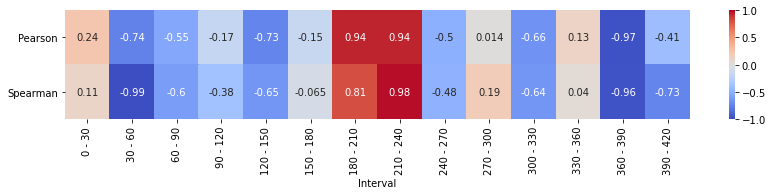

In [87]:
plt.figure(figsize = (14,2))
sns.heatmap(correlation_time.astype('float'), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)
plt.yticks([0.5,1.5], labels = ['Pearson', 'Spearman'], rotation = 0)

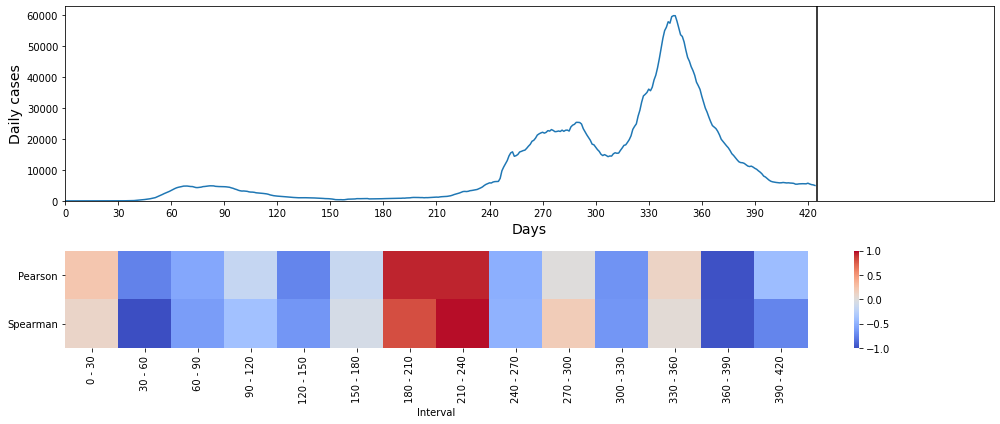

In [88]:
fig, ax = plt.subplots(2,1, figsize=(14,6), gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(daily[:425])
ax[0].set_xlim(0, 525)
ax[0].set_xlabel('Days', fontsize = 14)
ax[0].set_ylabel('Daily cases', fontsize = 14)
ax[0].set_ylim(0, 1.05*max(daily[:425]))
ax[0].set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360,390,420])
ax[0].vlines(425, 0, 1.05*max(daily[:425]))
sns.heatmap(correlation_time.astype('float'), vmin = -1, vmax = 1, cmap = 'coolwarm', ax = ax[1])
ax[1].set_yticks([0.5,1.5])
ax[1].set_yticklabels(['Pearson', 'Spearman'], rotation = 0)
plt.tight_layout()

In [89]:
pred_pw = pd.DataFrame({f'{window_size} days 5%': prediction_power,
                        f'{window_size} days 10%': prediction_not_much_power,
                        'N': f'{N_status}'})

In [90]:
pred_pw.to_csv(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Results/{country}_{window_size}_days_N_{N_status}_norm_by_daily_register_{samples}_samples.csv')

In [ ]:
tot_corr_fixed = pd.read_csv(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Results/Corrleation_{country}_N_fixed_spearman.csv')
tot_corr_free = pd.read_csv(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Results/Corrleation_{country}_N_free_spearman.csv')

In [ ]:
tot_corr_fixed = tot_corr_fixed.set_index('Unnamed: 0')
tot_corr_free = tot_corr_free.set_index('Unnamed: 0')

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(14,10), gridspec_kw={'height_ratios': [2, 1, 1]})
ax[0].plot(daily[:425])
ax[0].set_xlim(0, 526)
ax[0].set_xlabel('Days', fontsize = 12)
ax[0].set_ylabel('Daily cases', fontsize = 12)
ax[0].set_ylim(0, 1.05*max(daily[:425]))
ax[0].set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360,390,420])
ax[0].vlines(425, 0, 1.05*max(daily[:425]))
sns.heatmap(tot_corr_free, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True, ax = ax[1])
ax[1].set_yticks([0.5,1.5,2.5])
ax[1].set_yticklabels(['15 days', '20 days', '25 days'], rotation = 0)
ax[1].set_ylabel('Window size', fontsize = 12)
sns.heatmap(tot_corr_fixed, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True, ax = ax[2])
ax[2].set_yticks([0.5,1.5,2.5,3.5])
ax[2].set_yticklabels(['15 days', '20 days', '25 days', '30 days'], rotation = 0)
ax[2].set_ylabel('Window size', fontsize = 12)
plt.tight_layout()
plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/{country}&SEIRD_R0_N_both.png',
               bbox_inches = 'tight', dpi = 300)

In [91]:
r0_spearman = pd.DataFrame({'1 k': [0.195, 0.480, 0.435, 0.528],
                            '3 k': [-0.041, 0.182, 0.076, -0.046],
                            'Window size': ['30', '25', '20', '15']})

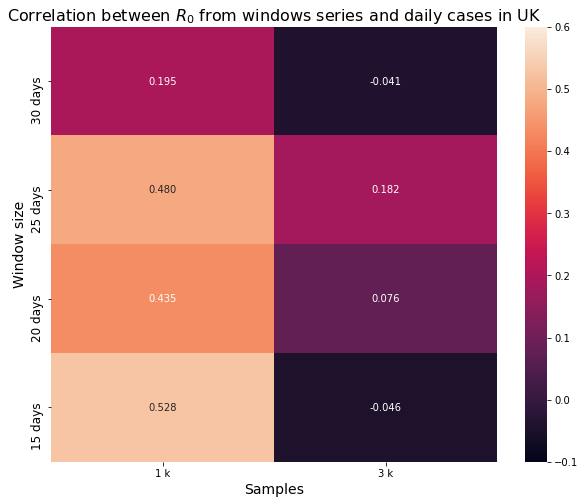

In [94]:
plt.figure(figsize=(10,8))
sns.heatmap(r0_spearman.drop(columns='Window size'), cmap = 'rocket', vmax = 0.6, vmin = -0.1,
            annot = True, fmt = '.3f')
plt.yticks([0.5,1.5,2.5,3.5], labels = ['30 days', '25 days', '20 days', '15 days'], fontsize = 12)
plt.xlabel('Samples', fontsize = 14)
plt.ylabel('Window size', fontsize = 14)
plt.title(r'Correlation between $R_0$ from windows series and daily cases in %s' %country, fontsize = 16)
plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/R0_correlation_matrix_{country}_samples_compare.png',
              bbox_inches = 'tight', dpi = 300)

In [748]:
folder_path = '/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Results'

results = pd.read_csv(f'{folder_path}/results.csv')
free_30 = pd.read_csv(f'{folder_path}/{country}_30_days_N_free_norm_by_daily_register.csv')
free_25 = pd.read_csv(f'{folder_path}/{country}_25_days_N_free_norm_by_daily_register.csv')
free_20 = pd.read_csv(f'{folder_path}/{country}_20_days_N_free_norm_by_daily_register.csv')
free_15 = pd.read_csv(f'{folder_path}/{country}_15_days_N_free_norm_by_daily_register.csv')
if country == 'UK':
    fixed1_15 = pd.read_csv(f'{folder_path}/{country}_15_days_N_fixed_norm_by_daily_register.csv')
    fixed1_20 = pd.read_csv(f'{folder_path}/{country}_20_days_N_fixed_norm_by_daily_register.csv')
    fixed1_25 = pd.read_csv(f'{folder_path}/{country}_25_days_N_fixed_norm_by_daily_register.csv')
    fixed1_30 = pd.read_csv(f'{folder_path}/{country}_30_days_N_fixed_norm_by_daily_register.csv')

    fixed2_15 = pd.read_csv(f'{folder_path}/{country}_15_days_N_5e6_norm_by_daily_register.csv')
    fixed2_20 = pd.read_csv(f'{folder_path}/{country}_20_days_N_5e6_norm_by_daily_register.csv')
    fixed2_25 = pd.read_csv(f'{folder_path}/{country}_25_days_N_5e6_norm_by_daily_register.csv')
    fixed2_30 = pd.read_csv(f'{folder_path}/{country}_30_days_N_5e6_norm_by_daily_register.csv')

    fixed3_15 = pd.read_csv(f'{folder_path}/{country}_15_days_N_pop_norm_by_daily_register.csv')
    fixed3_20 = pd.read_csv(f'{folder_path}/{country}_20_days_N_pop_norm_by_daily_register.csv')
    fixed3_25 = pd.read_csv(f'{folder_path}/{country}_25_days_N_pop_norm_by_daily_register.csv')
    fixed3_30 = pd.read_csv(f'{folder_path}/{country}_30_days_N_pop_norm_by_daily_register.csv')
elif country == 'India':
    fixed1_15 = pd.read_csv(f'{folder_path}/{country}_15_days_N_3e7_norm_by_daily_register.csv')
    fixed1_20 = pd.read_csv(f'{folder_path}/{country}_20_days_N_3e7_norm_by_daily_register.csv')
    fixed1_25 = pd.read_csv(f'{folder_path}/{country}_25_days_N_3e7_norm_by_daily_register.csv')
    fixed1_30 = pd.read_csv(f'{folder_path}/{country}_30_days_N_3e7_norm_by_daily_register.csv')

    fixed2_15 = pd.read_csv(f'{folder_path}/{country}_15_days_N_6e7_norm_by_daily_register.csv')
    fixed2_20 = pd.read_csv(f'{folder_path}/{country}_20_days_N_6e7_norm_by_daily_register.csv')
    fixed2_25 = pd.read_csv(f'{folder_path}/{country}_25_days_N_6e7_norm_by_daily_register.csv')
    fixed2_30 = pd.read_csv(f'{folder_path}/{country}_30_days_N_6e7_norm_by_daily_register.csv')
elif country == 'USA':
    pass

In [267]:
results.head()

,Window n,Predictive power 5%,N,Country,Window size
0,0,1.0,30000000,India,15
1,1,11.0,30000000,India,15
2,2,7.0,30000000,India,15
3,3,2.0,30000000,India,15
4,4,0.0,30000000,India,15


In [268]:
USA = results.loc[results['Country'] == 'USA']
UK = results.loc[results['Country'] == 'UK']
India = results.loc[results['Country'] == 'India']

(0.0, 16.0)

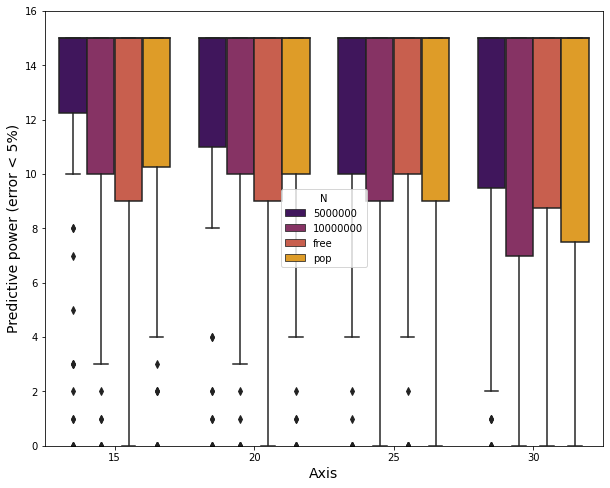

In [270]:
plt.figure(figsize=(10,8))
sns.boxplot(data=UK, x = 'Window size', y = 'Predictive power 5%', hue = 'N', palette = 'inferno')#, showfliers = False)
plt.xlabel('Axis', fontsize = 14)
plt.ylabel('Predictive power (error < 5%)', fontsize = 14)
plt.ylim(0,16)
#plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/predictive_power_5_{country}_samples_compare.png',
#              bbox_inches = 'tight', dpi = 300)

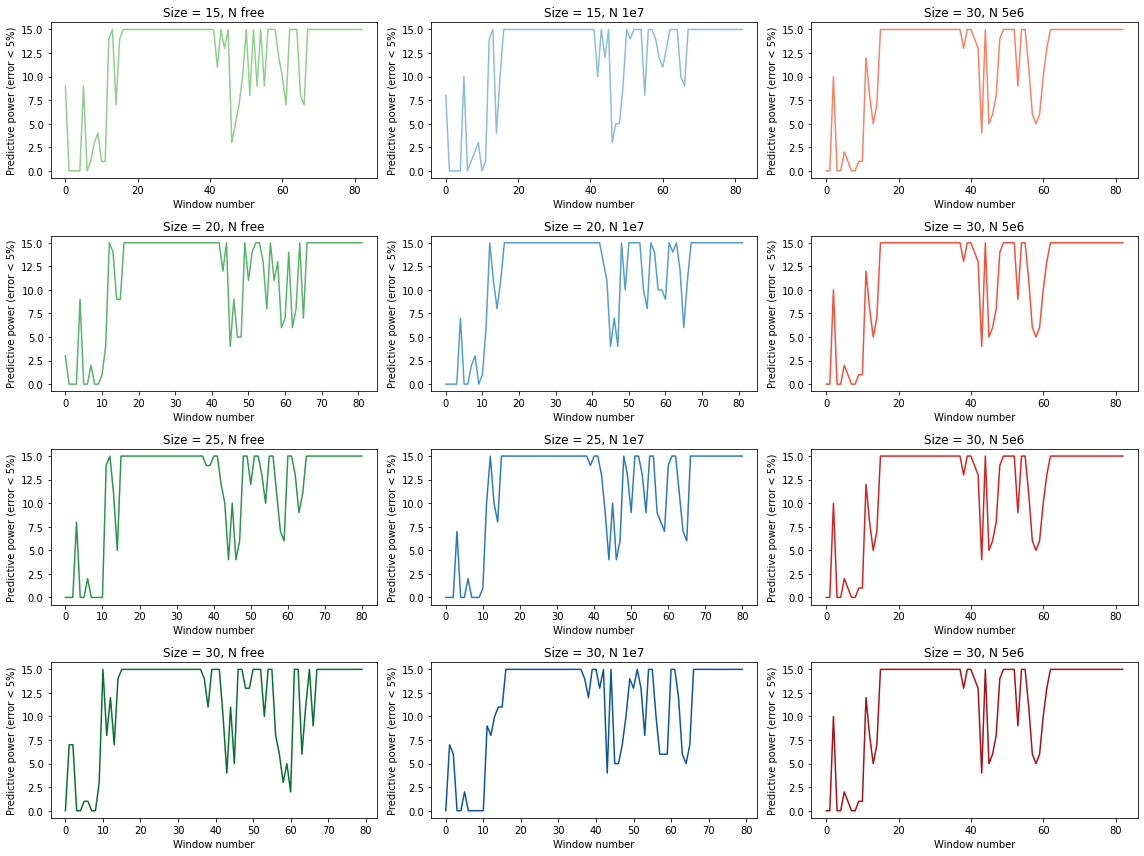

In [749]:
fig, ax = plt.subplots(4,3, figsize=(16,12))
sns.lineplot(data=free_15, x = 'Unnamed: 0', y = '15 days 5%', ax = ax[0,0], color = sns.color_palette('Greens')[2])
ax[0,0].set_title('Size = 15, N free')
ax[0,0].set_xlabel('Window number')
ax[0,0].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed1_15, x = 'Unnamed: 0', y = '15 days 5%', ax = ax[0,1], color = sns.color_palette('Blues')[2])
ax[0,1].set_title('Size = 15, N 1e7')
ax[0,1].set_xlabel('Window number')
ax[0,1].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed1_20, x = 'Unnamed: 0', y = '20 days 5%', ax = ax[1,1], color = sns.color_palette('Blues')[3])
ax[1,1].set_title('Size = 20, N 1e7')
ax[1,1].set_xlabel('Window number')
ax[1,1].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=free_20, x = 'Unnamed: 0', y = '20 days 5%', ax = ax[1,0], color = sns.color_palette('Greens')[3])
ax[1,0].set_title('Size = 20, N free')
ax[1,0].set_xlabel('Window number')
ax[1,0].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=free_25, x = 'Unnamed: 0', y = '25 days 5%', ax = ax[2,0], color = sns.color_palette('Greens')[4])
ax[2,0].set_title('Size = 25, N free')
ax[2,0].set_xlabel('Window number')
ax[2,0].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=free_30, x = 'Unnamed: 0', y = '30 days 5%', ax = ax[3,0], color = sns.color_palette('Greens')[5])
ax[3,0].set_title('Size = 30, N free')
ax[3,0].set_xlabel('Window number')
ax[3,0].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed1_25, x = 'Unnamed: 0', y = '25 days 5%', ax = ax[2,1], color = sns.color_palette('Blues')[4])
ax[2,1].set_title('Size = 25, N 1e7')
ax[2,1].set_xlabel('Window number')
ax[2,1].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed1_30, x = 'Unnamed: 0', y = '30 days 5%', ax = ax[3,1], color = sns.color_palette('Blues')[5])
ax[3,1].set_title('Size = 30, N 1e7')
ax[3,1].set_xlabel('Window number')
ax[3,1].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed2_30, x = 'Unnamed: 0', y = '30 days 5%', ax = ax[0,2], color = sns.color_palette('Reds')[2])
ax[0,2].set_title('Size = 30, N 5e6')
ax[0,2].set_xlabel('Window number')
ax[0,2].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed2_30, x = 'Unnamed: 0', y = '30 days 5%', ax = ax[1,2], color = sns.color_palette('Reds')[3])
ax[1,2].set_title('Size = 30, N 5e6')
ax[1,2].set_xlabel('Window number')
ax[1,2].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed2_30, x = 'Unnamed: 0', y = '30 days 5%', ax = ax[2,2], color = sns.color_palette('Reds')[4])
ax[2,2].set_title('Size = 30, N 5e6')
ax[2,2].set_xlabel('Window number')
ax[2,2].set_ylabel('Predictive power (error < 5%)')
sns.lineplot(data=fixed2_30, x = 'Unnamed: 0', y = '30 days 5%', ax = ax[3,2], color = sns.color_palette('Reds')[5])
ax[3,2].set_title('Size = 30, N 5e6')
ax[3,2].set_xlabel('Window number')
ax[3,2].set_ylabel('Predictive power (error < 5%)')
plt.tight_layout()
plt.savefig(f'/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/{country}_predictive_power_time_series_5.png',
              bbox_inches = 'tight', dpi = 300)

In [ ]:
results_new = results.loc[results['Window n'] > 40]
results_new = results_new.loc[results_new['Window n'] < 70]

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(data=results_new, x = 'Size', y = '5,00%', hue = 'N', palette = 'icefire', showfliers = False)
plt.xlabel('Axis', fontsize = 14)
plt.ylabel('Predictive power (error < 5%)', fontsize = 14)
plt.ylim(0,16)
plt.savefig('/home/pedroc/Documentos/pedro/Coronavirus/SantosDumont/LNCC-COVID-19-joaopedro/main/Graficos/predictive_power_5_zoom.png',
              bbox_inches = 'tight', dpi = 300)